In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2

from flygym.util.hybrid_turning_controller import NMFHybridTurning
from flygym.util.cpg_controller import plot_phase_amp_output_rules, sine_output

In [2]:
# Initialize the simulation
enable_adhesion = True
turn_mode = "amp"
run_time = 1.5
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_bottom",
    render_playspeed=0.1,
    actuator_kp=40,
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_gain=20,
)
nmf = NMFHybridTurning(
    turn_mode=turn_mode,
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

num_steps_base = int(run_time / nmf.timestep)

In [3]:
# Set turning variables:
turn_start_t = 0.5
turn_end_t = 1.1

turn_indicator_radius = 25

turn_start = int(turn_start_t / nmf.timestep)
turn_end = int(turn_end_t / nmf.timestep)

obs, info = nmf.reset()

obs_list = []
phases = []
amplitudes = []
stumble_active = []
retract_active = []
action = [0,0]
for i in trange(num_steps_base):
        
    if i == turn_start:
        action = [0,-1.0]
        print("Start turning")
    if i == turn_end:
        action = [0,0]
        print("Stop turning")

    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)
    stumble_active.append(nmf.stumble_active)
    retract_active.append(nmf.leg_retract_active)
    
    render_status = nmf.render()
    if render_status and i > turn_start and i < turn_end:
        last_frame = nmf.get_last_frame()
        cv2.circle(last_frame,(turn_indicator_radius,turn_indicator_radius), turn_indicator_radius, (0, 0, 255), -1)

    phases.append(nmf.cpg.phase)
    amplitudes.append(nmf.cpg.amplitude)

 33%|███▎      | 5016/15000 [00:56<01:47, 93.04it/s] 

Start turning
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▎      | 5033/15000 [00:56<01:52, 88.97it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▎      | 5049/15000 [00:56<01:38, 101.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▎      | 5060/15000 [00:56<01:58, 84.04it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▍      | 5084/15000 [00:56<02:14, 73.59it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▍      | 5118/15000 [00:57<02:08, 77.18it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▍      | 5135/15000 [00:57<02:04, 78.98it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▍      | 5144/15000 [00:57<02:03, 80.03it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 34%|███▍      | 5169/15000 [00:58<02:08, 76.23it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▍      | 5203/15000 [00:58<02:01, 80.47it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▍      | 5218/15000 [00:58<01:46, 92.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▍      | 5228/15000 [00:58<02:02, 79.58it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▍      | 5237/15000 [00:58<02:29, 65.51it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▌      | 5269/15000 [00:59<01:55, 84.32it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▌      | 5279/15000 [00:59<02:08, 75.58it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▌      | 5300/15000 [00:59<02:03, 78.73it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▌      | 5309/15000 [00:59<02:33, 63.22it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 35%|███▌      | 5322/15000 [01:00<02:28, 65.15it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 36%|███▌      | 5356/15000 [01:00<02:09, 74.57it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 36%|███▌      | 5371/15000 [01:00<01:49, 87.93it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 36%|███▌      | 5381/15000 [01:00<02:13, 71.90it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 36%|███▌      | 5407/15000 [01:01<02:08, 74.80it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 36%|███▋      | 5441/15000 [01:01<02:01, 78.56it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 36%|███▋      | 5450/15000 [01:01<01:58, 80.27it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 36%|███▋      | 5475/15000 [01:02<02:04, 76.23it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 37%|███▋      | 5509/15000 [01:02<01:57, 80.81it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 37%|███▋      | 5526/15000 [01:02<01:56, 81.47it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 37%|███▋      | 5536/15000 [01:02<01:51, 84.51it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 37%|███▋      | 5545/15000 [01:02<02:07, 74.09it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 37%|███▋      | 5577/15000 [01:03<02:00, 78.06it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 37%|███▋      | 5594/15000 [01:03<01:58, 79.63it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 37%|███▋      | 5622/15000 [01:03<01:49, 85.85it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5631/15000 [01:04<02:01, 76.91it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5662/15000 [01:04<01:57, 79.49it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5679/15000 [01:04<01:53, 82.15it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5695/15000 [01:04<01:36, 96.82it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5706/15000 [01:04<01:59, 77.82it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5715/15000 [01:05<02:11, 70.59it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5746/15000 [01:05<01:45, 87.95it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5757/15000 [01:05<01:56, 79.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 38%|███▊      | 5774/15000 [01:05<02:07, 72.54it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▊      | 5796/15000 [01:06<01:54, 80.59it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▊      | 5806/15000 [01:06<02:07, 72.28it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▉      | 5829/15000 [01:06<01:52, 81.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▉      | 5839/15000 [01:06<02:06, 72.17it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▉      | 5865/15000 [01:07<01:52, 81.29it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▉      | 5875/15000 [01:07<02:05, 72.76it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▉      | 5897/15000 [01:07<01:57, 77.53it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▉      | 5915/15000 [01:07<02:03, 73.27it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 39%|███▉      | 5924/15000 [01:08<02:19, 65.04it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|███▉      | 5948/15000 [01:08<01:56, 77.46it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|███▉      | 5957/15000 [01:08<02:11, 68.85it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|███▉      | 5983/15000 [01:08<01:49, 82.69it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|███▉      | 5993/15000 [01:08<02:10, 68.99it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|████      | 6018/15000 [01:09<01:48, 83.07it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|████      | 6028/15000 [01:09<02:02, 73.39it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|████      | 6050/15000 [01:09<01:54, 78.39it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 40%|████      | 6059/15000 [01:09<02:21, 63.35it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████      | 6084/15000 [01:10<01:55, 76.87it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████      | 6094/15000 [01:10<02:14, 66.45it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████      | 6121/15000 [01:10<02:04, 71.25it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████      | 6138/15000 [01:11<01:58, 74.91it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████      | 6155/15000 [01:11<01:52, 78.72it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████      | 6169/15000 [01:11<01:39, 88.67it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████▏     | 6189/15000 [01:11<01:55, 76.50it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████▏     | 6206/15000 [01:11<01:45, 83.51it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 41%|████▏     | 6223/15000 [01:11<01:40, 87.65it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 42%|████▏     | 6257/15000 [01:12<01:32, 94.30it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 42%|████▏     | 6274/15000 [01:12<01:31, 95.16it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 42%|████▏     | 6308/15000 [01:12<01:28, 98.30it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 42%|████▏     | 6325/15000 [01:13<01:31, 94.51it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 42%|████▏     | 6342/15000 [01:13<01:32, 93.33it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 42%|████▏     | 6367/15000 [01:13<01:32, 93.08it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6393/15000 [01:13<01:37, 87.88it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6410/15000 [01:13<01:35, 90.06it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6427/15000 [01:14<01:35, 89.82it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6444/15000 [01:14<01:38, 86.52it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6461/15000 [01:14<01:38, 86.37it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6495/15000 [01:14<01:34, 89.90it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6512/15000 [01:15<01:35, 88.78it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 43%|████▎     | 6524/15000 [01:15<01:30, 93.57it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▎     | 6534/15000 [01:15<01:54, 74.09it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▎     | 6562/15000 [01:15<01:36, 87.52it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▍     | 6572/15000 [01:15<01:47, 78.72it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▍     | 6591/15000 [01:16<01:46, 79.16it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▍     | 6614/15000 [01:16<01:52, 74.31it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▍     | 6631/15000 [01:16<01:46, 78.86it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▍     | 6646/15000 [01:16<01:30, 92.78it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 44%|████▍     | 6656/15000 [01:16<01:40, 83.25it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▍     | 6677/15000 [01:17<01:47, 77.53it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▍     | 6699/15000 [01:17<02:00, 69.13it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▍     | 6716/15000 [01:17<01:49, 75.55it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▍     | 6728/15000 [01:17<01:39, 83.05it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▌     | 6750/15000 [01:18<01:50, 74.60it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▌     | 6784/15000 [01:18<01:40, 81.75it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▌     | 6801/15000 [01:18<01:38, 83.27it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 45%|████▌     | 6813/15000 [01:18<01:31, 89.83it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▌     | 6835/15000 [01:19<01:43, 78.76it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▌     | 6852/15000 [01:19<01:41, 80.60it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▌     | 6865/15000 [01:19<01:30, 90.17it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▌     | 6875/15000 [01:19<01:49, 74.36it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▌     | 6886/15000 [01:19<01:53, 71.39it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▌     | 6920/15000 [01:20<01:40, 80.77it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▌     | 6937/15000 [01:20<01:32, 87.53it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 46%|████▋     | 6971/15000 [01:20<01:31, 87.78it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 6988/15000 [01:21<01:32, 87.00it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 7005/15000 [01:21<01:29, 89.03it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 7036/15000 [01:21<01:20, 99.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 7047/15000 [01:21<01:27, 91.00it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 7073/15000 [01:22<01:32, 85.46it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 7090/15000 [01:22<01:30, 87.85it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 7107/15000 [01:22<01:29, 87.75it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 47%|████▋     | 7117/15000 [01:22<01:28, 89.23it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7127/15000 [01:22<01:39, 79.04it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7158/15000 [01:23<01:38, 79.49it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7187/15000 [01:23<01:29, 87.43it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7197/15000 [01:23<01:37, 80.11it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7209/15000 [01:23<01:41, 76.60it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7242/15000 [01:24<01:22, 94.45it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7253/15000 [01:24<01:31, 84.36it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 48%|████▊     | 7263/15000 [01:24<01:48, 71.43it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▊     | 7291/15000 [01:24<01:32, 83.70it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▊     | 7301/15000 [01:24<01:41, 76.15it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▉     | 7319/15000 [01:25<01:46, 72.19it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▉     | 7344/15000 [01:25<01:30, 85.03it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▉     | 7354/15000 [01:25<01:40, 76.30it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▉     | 7363/15000 [01:25<01:51, 68.41it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▉     | 7393/15000 [01:26<01:28, 86.17it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 49%|████▉     | 7403/15000 [01:26<01:43, 73.59it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|████▉     | 7429/15000 [01:26<01:27, 86.97it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|████▉     | 7439/15000 [01:26<01:35, 79.47it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|████▉     | 7464/15000 [01:27<01:38, 76.81it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|████▉     | 7476/15000 [01:27<01:28, 85.23it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|████▉     | 7498/15000 [01:27<01:35, 78.92it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|█████     | 7515/15000 [01:27<01:26, 86.59it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|█████     | 7532/15000 [01:27<01:21, 91.80it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 50%|█████     | 7566/15000 [01:28<01:15, 98.27it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 51%|█████     | 7583/15000 [01:28<01:12, 101.87it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 51%|█████     | 7617/15000 [01:28<01:10, 105.11it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 51%|█████     | 7634/15000 [01:28<01:10, 104.06it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 51%|█████     | 7668/15000 [01:29<01:12, 101.21it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 51%|█████▏    | 7702/15000 [01:29<01:12, 100.68it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 51%|█████▏    | 7719/15000 [01:29<01:11, 101.41it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 52%|█████▏    | 7753/15000 [01:29<01:15, 96.58it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 52%|█████▏    | 7770/15000 [01:30<01:13, 97.96it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 52%|█████▏    | 7787/15000 [01:30<01:13, 97.61it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 52%|█████▏    | 7821/15000 [01:30<01:09, 103.49it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 52%|█████▏    | 7855/15000 [01:31<01:12, 98.53it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 52%|█████▏    | 7872/15000 [01:31<01:10, 100.54it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 53%|█████▎    | 7906/15000 [01:31<01:09, 102.57it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 53%|█████▎    | 7923/15000 [01:31<01:07, 104.21it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 53%|█████▎    | 7957/15000 [01:31<01:10, 99.64it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 53%|█████▎    | 7974/15000 [01:32<01:10, 99.93it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 53%|█████▎    | 7991/15000 [01:32<01:10, 99.05it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 53%|█████▎    | 8008/15000 [01:32<01:10, 99.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 54%|█████▎    | 8041/15000 [01:32<01:01, 113.06it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 54%|█████▍    | 8064/15000 [01:33<01:13, 94.48it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 54%|█████▍    | 8076/15000 [01:33<01:16, 91.08it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 54%|█████▍    | 8110/15000 [01:33<01:11, 95.75it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 54%|█████▍    | 8142/15000 [01:33<01:07, 101.09it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 54%|█████▍    | 8153/15000 [01:34<01:18, 86.92it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▍    | 8175/15000 [01:34<01:20, 84.85it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▍    | 8185/15000 [01:34<01:29, 76.01it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▍    | 8211/15000 [01:34<01:20, 84.45it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▍    | 8230/15000 [01:35<01:29, 75.89it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▍    | 8246/15000 [01:35<01:20, 83.58it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▌    | 8277/15000 [01:35<01:07, 99.31it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▌    | 8298/15000 [01:35<01:20, 82.96it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 55%|█████▌    | 8314/15000 [01:36<01:17, 86.83it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▌    | 8331/15000 [01:36<01:11, 92.86it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▌    | 8363/15000 [01:36<01:01, 107.50it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▌    | 8386/15000 [01:36<01:13, 89.52it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▌    | 8399/15000 [01:36<01:14, 88.23it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▌    | 8416/15000 [01:37<01:12, 90.39it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▌    | 8433/15000 [01:37<01:14, 88.24it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▋    | 8454/15000 [01:37<01:17, 84.16it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 56%|█████▋    | 8467/15000 [01:37<01:20, 81.50it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8501/15000 [01:38<01:14, 87.51it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8518/15000 [01:38<01:15, 86.05it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8529/15000 [01:38<01:11, 90.28it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8539/15000 [01:38<01:23, 77.02it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8569/15000 [01:38<01:23, 76.70it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8586/15000 [01:39<01:18, 81.42it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8599/15000 [01:39<01:11, 89.57it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 57%|█████▋    | 8609/15000 [01:39<01:18, 81.33it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8634/15000 [01:39<01:10, 90.34it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8644/15000 [01:39<01:19, 80.14it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8663/15000 [01:40<01:23, 75.59it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8687/15000 [01:40<01:11, 88.45it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8697/15000 [01:40<01:21, 77.78it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8706/15000 [01:40<01:27, 72.04it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8730/15000 [01:41<01:22, 76.08it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8755/15000 [01:41<01:09, 89.26it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 58%|█████▊    | 8765/15000 [01:41<01:24, 73.40it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▊    | 8785/15000 [01:41<01:24, 73.76it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▊    | 8804/15000 [01:42<01:29, 69.34it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▊    | 8812/15000 [01:42<01:35, 65.12it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▉    | 8840/15000 [01:42<01:12, 84.39it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▉    | 8850/15000 [01:42<01:24, 73.10it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▉    | 8875/15000 [01:43<01:26, 70.85it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▉    | 8892/15000 [01:43<01:17, 79.26it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▉    | 8908/15000 [01:43<01:04, 94.62it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 59%|█████▉    | 8919/15000 [01:43<01:17, 78.03it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 60%|█████▉    | 8943/15000 [01:43<01:20, 74.94it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 60%|█████▉    | 8960/15000 [01:44<01:13, 81.76it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 60%|█████▉    | 8977/15000 [01:44<01:10, 84.90it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 60%|█████▉    | 8994/15000 [01:44<01:10, 84.96it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 60%|██████    | 9028/15000 [01:44<01:03, 94.07it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 60%|██████    | 9045/15000 [01:44<01:02, 95.04it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 61%|██████    | 9079/15000 [01:45<01:01, 96.01it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 61%|██████    | 9113/15000 [01:45<01:00, 97.68it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 61%|██████    | 9130/15000 [01:45<00:58, 99.91it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 61%|██████    | 9160/15000 [01:46<01:00, 96.06it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 61%|██████    | 9171/15000 [01:46<01:09, 83.63it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 61%|██████▏   | 9196/15000 [01:46<01:04, 89.74it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 61%|██████▏   | 9206/15000 [01:46<01:10, 81.96it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 62%|██████▏   | 9232/15000 [01:47<01:13, 78.53it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 62%|██████▏   | 9249/15000 [01:47<01:06, 85.97it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 62%|██████▏   | 9280/15000 [01:47<00:58, 97.30it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 62%|██████▏   | 9301/15000 [01:47<01:12, 78.43it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 62%|██████▏   | 9317/15000 [01:48<01:12, 78.85it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 62%|██████▏   | 9349/15000 [01:48<01:02, 90.90it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 62%|██████▏   | 9359/15000 [01:48<01:14, 75.80it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9384/15000 [01:48<01:06, 85.02it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9394/15000 [01:49<01:13, 76.03it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9418/15000 [01:49<01:10, 79.66it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9437/15000 [01:49<01:19, 69.88it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9451/15000 [01:49<01:06, 83.58it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9461/15000 [01:50<01:17, 71.32it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9487/15000 [01:50<01:16, 71.62it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9503/15000 [01:50<01:06, 82.23it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 63%|██████▎   | 9521/15000 [01:50<01:17, 71.14it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▎   | 9538/15000 [01:51<01:09, 78.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▎   | 9555/15000 [01:51<01:07, 80.45it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▍   | 9567/15000 [01:51<01:01, 88.02it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▍   | 9589/15000 [01:51<01:12, 75.08it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▍   | 9606/15000 [01:51<01:08, 78.95it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▍   | 9623/15000 [01:52<01:04, 83.42it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▍   | 9637/15000 [01:52<00:56, 94.30it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▍   | 9657/15000 [01:52<01:10, 75.39it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 64%|██████▍   | 9674/15000 [01:52<01:06, 80.49it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▍   | 9686/15000 [01:52<01:01, 86.92it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▍   | 9696/15000 [01:53<01:12, 73.01it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▍   | 9725/15000 [01:53<01:10, 74.89it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▍   | 9739/15000 [01:53<01:01, 86.02it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▌   | 9759/15000 [01:53<01:14, 70.23it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▌   | 9776/15000 [01:54<01:10, 74.46it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▌   | 9791/15000 [01:54<00:59, 87.66it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 65%|██████▌   | 9801/15000 [01:54<01:13, 70.58it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9827/15000 [01:54<01:11, 72.51it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9844/15000 [01:55<01:03, 81.04it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9856/15000 [01:55<00:58, 88.29it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9866/15000 [01:55<01:17, 66.34it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9892/15000 [01:55<01:07, 75.53it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9912/15000 [01:56<01:19, 63.72it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9926/15000 [01:56<01:07, 75.30it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▌   | 9935/15000 [01:56<01:22, 61.15it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▋   | 9962/15000 [01:56<01:03, 79.18it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 66%|██████▋   | 9972/15000 [01:56<01:09, 72.04it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 9989/15000 [01:57<01:17, 64.49it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10010/15000 [01:57<01:09, 71.63it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10028/15000 [01:57<01:15, 65.52it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10036/15000 [01:58<01:28, 56.29it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10063/15000 [01:58<01:12, 67.95it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10079/15000 [01:58<01:22, 59.92it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10086/15000 [01:58<01:37, 50.36it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10115/15000 [01:59<01:07, 72.45it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 67%|██████▋   | 10124/15000 [01:59<01:22, 59.08it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10146/15000 [01:59<01:11, 67.82it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10155/15000 [02:00<01:25, 56.36it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10162/15000 [02:00<01:23, 58.04it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10175/15000 [02:00<01:43, 46.44it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10183/15000 [02:00<01:32, 52.07it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10197/15000 [02:00<01:36, 49.67it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10214/15000 [02:01<01:32, 51.84it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10233/15000 [02:01<01:18, 61.05it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10241/15000 [02:01<01:25, 55.70it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 68%|██████▊   | 10268/15000 [02:02<01:01, 77.56it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▊   | 10278/15000 [02:02<01:05, 72.20it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▊   | 10295/15000 [02:02<01:11, 66.14it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▉   | 10320/15000 [02:02<01:02, 74.79it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▉   | 10337/15000 [02:03<00:57, 81.30it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▉   | 10354/15000 [02:03<00:53, 86.31it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▉   | 10388/15000 [02:03<00:49, 93.69it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▉   | 10405/15000 [02:03<00:51, 89.39it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 69%|██████▉   | 10422/15000 [02:03<00:48, 93.83it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 70%|██████▉   | 10456/15000 [02:04<00:46, 98.56it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 70%|██████▉   | 10473/15000 [02:04<00:45, 99.62it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 70%|███████   | 10507/15000 [02:04<00:44, 99.91it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 70%|███████   | 10524/15000 [02:04<00:46, 97.19it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 70%|███████   | 10558/15000 [02:05<00:43, 102.19it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 70%|███████   | 10575/15000 [02:05<00:43, 102.29it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 71%|███████   | 10609/15000 [02:05<00:43, 100.34it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 71%|███████   | 10626/15000 [02:05<00:46, 94.54it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 71%|███████   | 10660/15000 [02:06<00:43, 99.85it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 71%|███████   | 10677/15000 [02:06<00:42, 101.80it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 71%|███████▏  | 10711/15000 [02:06<00:42, 101.73it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 72%|███████▏  | 10745/15000 [02:07<00:43, 98.10it/s] 

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 72%|███████▏  | 10762/15000 [02:07<00:43, 97.51it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 72%|███████▏  | 10779/15000 [02:07<00:43, 97.91it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 72%|███████▏  | 10796/15000 [02:07<00:43, 97.53it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 72%|███████▏  | 10823/15000 [02:07<00:45, 91.06it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 72%|███████▏  | 10833/15000 [02:08<00:53, 78.29it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 72%|███████▏  | 10860/15000 [02:08<00:49, 83.74it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10880/15000 [02:08<00:53, 77.13it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10889/15000 [02:09<01:10, 58.36it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10909/15000 [02:09<01:04, 63.16it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10931/15000 [02:09<00:57, 70.18it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10940/15000 [02:09<01:05, 61.60it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10956/15000 [02:10<01:12, 55.71it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10966/15000 [02:10<01:16, 52.53it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 10993/15000 [02:10<01:01, 65.67it/s]

[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]
[ 0.  -0.5] [3, 5]


 73%|███████▎  | 11001/15000 [02:10<01:04, 61.73it/s]

Stop turning


100%|██████████| 15000/15000 [03:04<00:00, 81.17it/s] 


In [4]:
adhesion_str = "adhesion" if enable_adhesion else "no_adhesion"
video_path = Path(f"../../tripod_{adhesion_str}_turn_testadh.mp4")
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

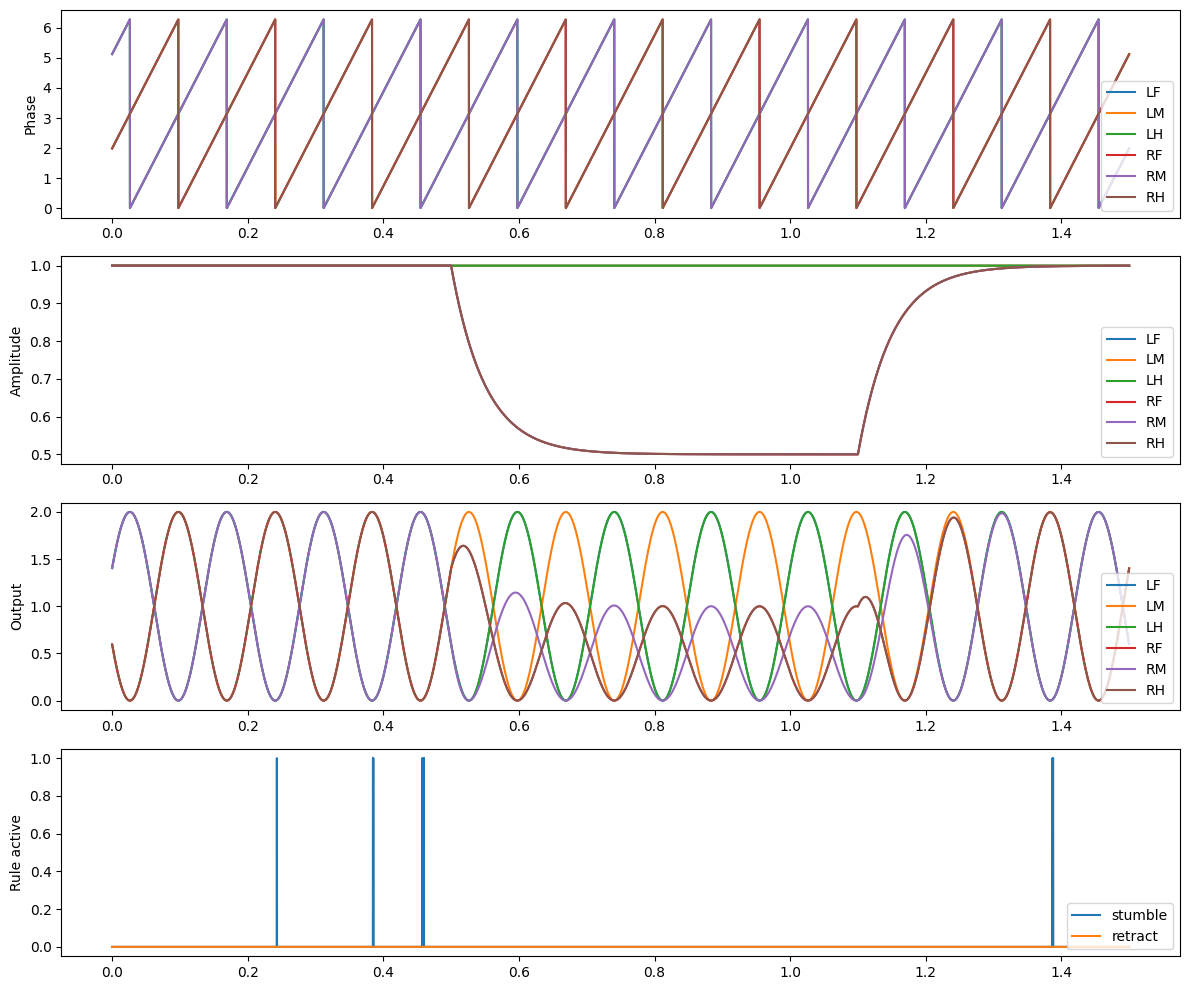

In [5]:
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
plot_phase_amp_output_rules(
    phases,
    amplitudes,
    sine_output(phases, amplitudes),
    [stumble_active,retract_active],
    labels=legs,
    rule_labels=["stumble","retract"],
    timestep=nmf.timestep
)
plt.show()